In [1]:
import torch
import numpy as np
from tqdm.auto import tqdm

from rcp.training.training import train_image_classifier
from rcp.cp.prediction import prediction
from rcp.cp.conformal_prediction import conf_pred
from rcp.cp.certificate import reliability_eval
from rcp.datasets import load_dataset
from rcp.models import create_image_classifier
from rcp.utils import *

In [2]:
hparams = {
    "dataset_path": "/ceph/ssd/staff/scholten/data/",
    "arch": "ResNet18",
    "dataset": "CIFAR10",
    "device": "cuda",
    "model_seed": 42,
    "in_channels": 3,
    "out_channels": 10,
    "batch_size_training": 128,
    "batch_size_inference": 300,
    "lr": 0.01,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "max_epochs": 400,
    "early_stopping": 100,
    "lr_scheduler": "cosine",
    "pretrained": False,
    "k_t": 100, # number of training partitions
    "k_c": 40, # number of calibration partitions
    "alpha": 0.1,
    "score_function": "HPS",
    "with_softmax": True
}

In [ ]:
list_train_data, test_data, means, stds = load_dataset(hparams)

In [ ]:
models = []

for i, train_data in tqdm(enumerate(list_train_data)):

    set_random_seed(hparams['model_seed'] * (i+1))
    model = create_image_classifier(hparams, means[i], stds[i])

    set_random_seed(hparams['model_seed'] * (i+1))
    model = train_image_classifier(model, train_data, hparams)

    models.append(model.cpu().state_dict())

In [5]:
# calibration test split
val_idx = np.arange(len(test_data))
set_random_seed(seed=0)
np.random.shuffle(val_idx)
cal_idx = val_idx[:1000]
test_idx = val_idx[1000:]

In [6]:
# inference
experiment = {"hparams": hparams, "models": models}
params = (test_data, means, stds, experiment, hparams, test_idx)
all_logits, targets, hashes, accs, stats_time = prediction(*params)
print(f"Avg. accuracy on test set: {np.mean(accs):.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Avg. accuracy on test set: 0.39


# Conformal prediction (majority prediction sets)

In [7]:
cal_indices = [[] for _ in range(hparams['k_c'])]
for idx, (image, label) in tqdm(enumerate(test_data), total=len(test_data)):
    if idx not in cal_idx:
        continue
    index = int(image.sum()) % hparams['k_c']
    cal_indices[index].append(idx)
cal_indices = [np.array(x) for x in cal_indices]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
params = (test_idx, hparams, cal_indices, all_logits, targets, hashes)
conformal_result = conf_pred(*params)

  0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
# conformal prediction eval
PS = conformal_result[0]
PS_val = PS[np.arange(len(test_idx)), targets[test_idx]]
num_classes = hparams['out_channels']

stats_prediction_sets = {
    "empirical_coverage": PS_val.mean(),
    "avg_set_size": PS.sum(1).mean(),
    "singleton_hit_ratio": PS_val[PS.sum(1) == 1].mean(),
    "singleton_proportion": (PS.sum(1) == 1).sum()/PS.shape[0],
    "zero_sets": (PS.sum(1) == 0).sum()/PS.shape[0],
    "full_sets": (PS.sum(1) == num_classes).sum()/PS.shape[0]
}

In [10]:
print(f"Empirical coverage: {stats_prediction_sets['empirical_coverage']:.3f}")
print(f"Average set size: {stats_prediction_sets['avg_set_size']:.3f}")

Empirical coverage: 0.909
Average set size: 3.192


# Certification

In [11]:
params = hparams, targets, cal_indices, test_idx, conformal_result
certificates = reliability_eval(*params)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
plot = {k : np.diag(certificates[k]) for k in certificates}

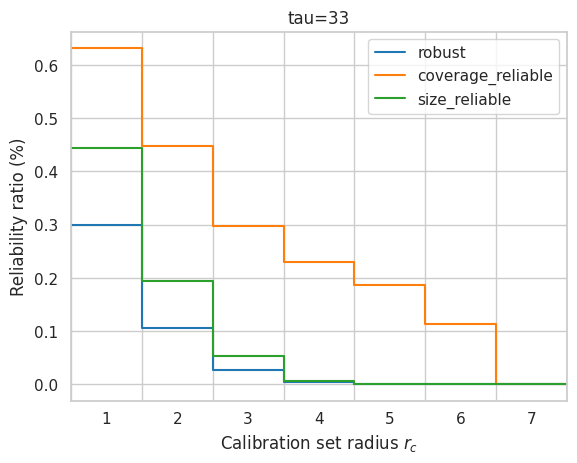

In [13]:
xticklabels = np.arange(1,8, dtype=object)
xticks = np.arange(0, 8, step=1).astype(int)
xlabel = "Calibration set radius $r_c$"
ylabel = "Reliability ratio (%)"
title = f"tau={conformal_result[2]}"

step_plot(plot, xticks, xticklabels, xlabel, ylabel, title)